In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=True, float_l=True, alpha_aux=[Normal(0,2), Normal(0,2)]),
               LossTracker(),SaveBest('weights/best_ie3.h5'),EarlyStopping(10)])

1: Train=868.0300701904297 Valid=767.054736328125
2: Train=634.4367858886719 Valid=535.0216778564453
3: Train=499.04460083007814 Valid=471.51139892578124
4: Train=459.08541412353514 Valid=445.61116577148437
5: Train=436.9772674560547 Valid=430.1282452392578
6: Train=423.4132403564453 Valid=424.42599609375
7: Train=415.055908203125 Valid=411.17961669921874
8: Train=397.88460632324217 Valid=417.973125
9: Train=395.3365737915039 Valid=402.2022308349609
10: Train=389.7520413208008 Valid=403.6433819580078
11: Train=383.22545837402345 Valid=386.6323309326172
12: Train=379.3493127441406 Valid=383.413759765625
13: Train=371.8517254638672 Valid=374.50346130371094
14: Train=367.8199472045898 Valid=375.5438677978516
15: Train=360.03014221191404 Valid=368.98120971679685
16: Train=358.5081977844238 Valid=373.4811804199219
17: Train=357.9845904541016 Valid=363.11142395019533
18: Train=351.0553228759766 Valid=356.7553521728516
19: Train=348.7665270996094 Valid=356.880009765625
20: Train=348.585083923

In [8]:
model.save('weights/Inferno_Test_exact_bm3.h5')

In [9]:
model.load('weights/Inferno_Test_exact_bm3.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,6,1.0
1,2,1.0
2,5,1.0
3,8,1.0
4,4,1.0


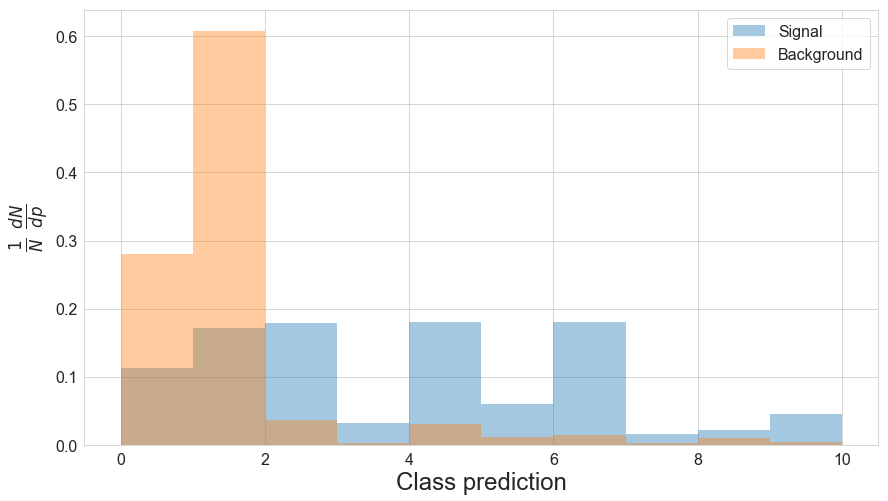

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,6,1.0,6
1,2,1.0,2
2,5,1.0,5
3,8,1.0,8
4,4,1.0,4


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.0000))

In [17]:
f_s, f_b

(tensor([0.1125, 0.1717, 0.1789, 0.0320, 0.1809, 0.0605, 0.1803, 0.0161, 0.0218,
         0.0453]),
 tensor([0.2797, 0.6083, 0.0364, 0.0022, 0.0307, 0.0120, 0.0138, 0.0023, 0.0097,
         0.0048]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([285.3741, 616.8481,  45.3787,   3.8021,  39.7087,  14.9904,  22.8434,
           3.1254,  10.8229,   7.1062]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([27.42177391, 27.27934647, 27.14233398, 27.01172066, 26.8861084 ,
       26.76685524, 26.65243149, 26.54369926, 26.44047737, 26.34235573,
       26.24930763, 26.16171455, 26.07906532, 26.00143433, 25.92853928,
       25.86075783, 25.79783821, 25.73941231, 25.68580627, 25.63671684,
       25.59233665, 25.55220604, 25.51672554, 25.48536301, 25.45859337,
       25.43640709, 25.41795349, 25.40357971, 25.39324188, 25.38747025,
       25.38518333, 25.38735771, 25.3932457 , 25.403162  , 25.4164505 ,
       25.4342041 , 25.45525169, 25.48012543, 25.50871468, 25.54084015,
       25.576437  , 25.61578751, 25.65889168, 25.70498657, 25.75483131,
       25.80796623, 25.8643589 , 25.92424774, 25.98758888, 26.0537281 ,
       26.12310791, 26.19608879, 26.27202415, 26.35072708, 26.43293762,
       26.51827049, 26.60676575, 26.69782257, 26.7922802 , 26.88956642,
       26.98979187])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

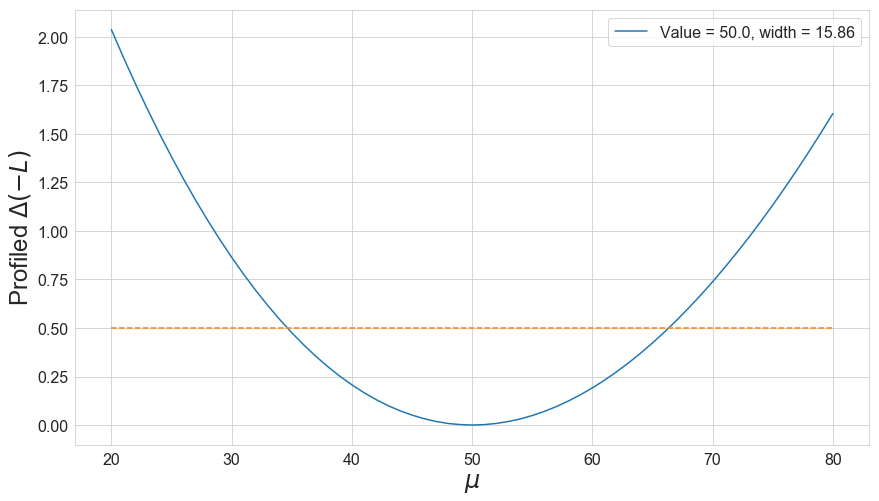

In [23]:
plot_likelihood(y-y.min())

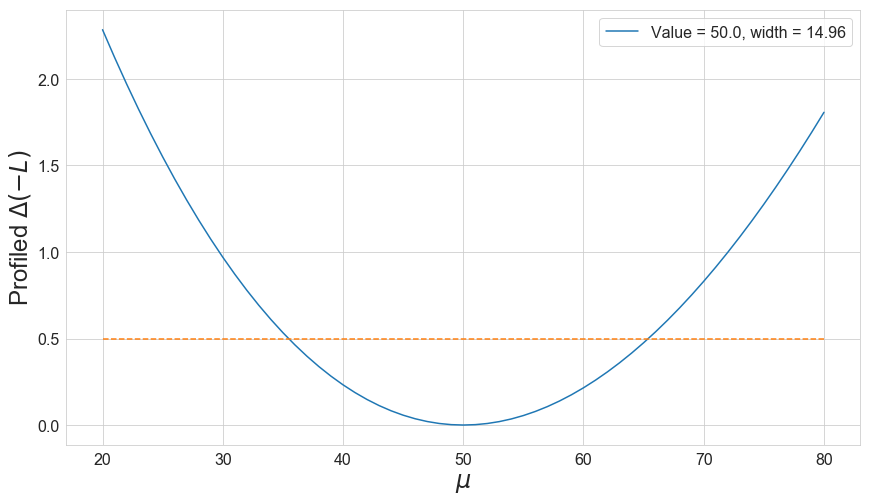

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,6,1.0,6,6,6,6,6,6,6,6,6,6,6
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,8,1.0,8,8,8,8,8,8,8,8,8,8,8
4,4,1.0,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999996,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999997,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999998,1,0.0,1,1,1,1,1,1,1,1,1,1,1


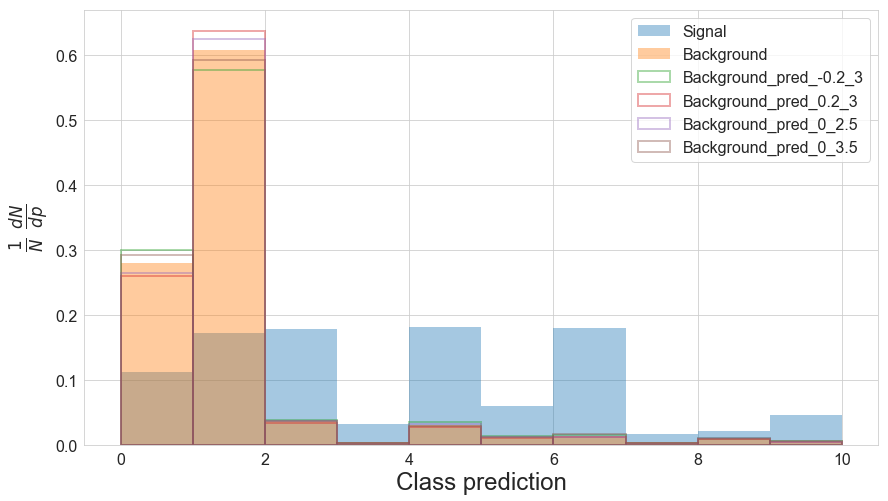

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.2855, 0.5954, 0.0384, 0.0014, 0.0359, 0.0133, 0.0132, 0.0017, 0.0109,
        0.0042])
tensor([0.3004, 0.5780, 0.0384, 0.0023, 0.0344, 0.0131, 0.0153, 0.0025, 0.0103,
        0.0053])
tensor([0.3132, 0.5625, 0.0381, 0.0033, 0.0329, 0.0128, 0.0178, 0.0033, 0.0096,
        0.0064])
tensor([0.2649, 0.6257, 0.0365, 0.0013, 0.0322, 0.0121, 0.0116, 0.0016, 0.0104,
        0.0037])
tensor([0.2797, 0.6083, 0.0364, 0.0022, 0.0307, 0.0120, 0.0138, 0.0023, 0.0097,
        0.0048])
tensor([0.2926, 0.5927, 0.0362, 0.0032, 0.0291, 0.0117, 0.0163, 0.0031, 0.0091,
        0.0059])
tensor([0.2451, 0.6553, 0.0342, 0.0012, 0.0283, 0.0110, 0.0104, 0.0014, 0.0096,
        0.0034])
tensor([0.2599, 0.6379, 0.0342, 0.0021, 0.0268, 0.0109, 0.0126, 0.0021, 0.0090,
        0.0045])
tensor([0.2728, 0.6224, 0.0339, 0.0031, 0.0253, 0.0105, 0.0151, 0.0029, 0.0084,
        0.0055])


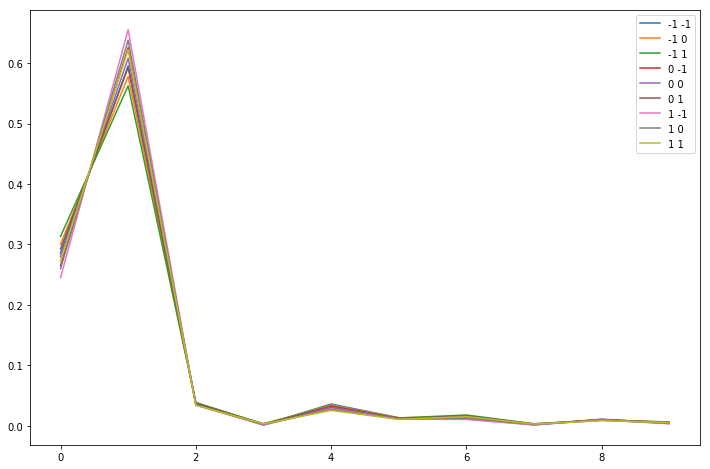

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

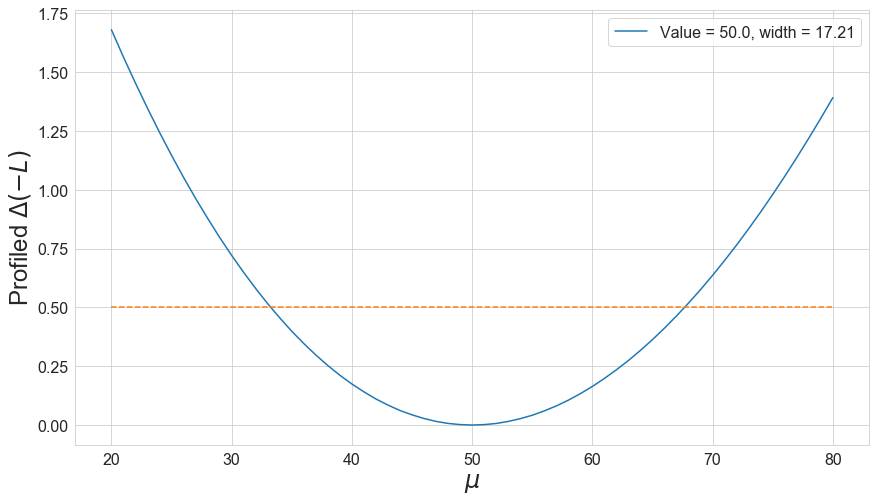

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

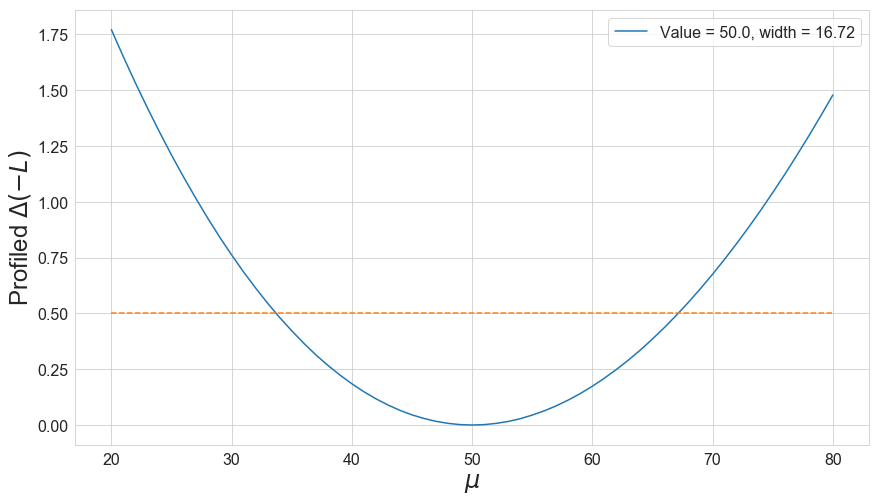

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

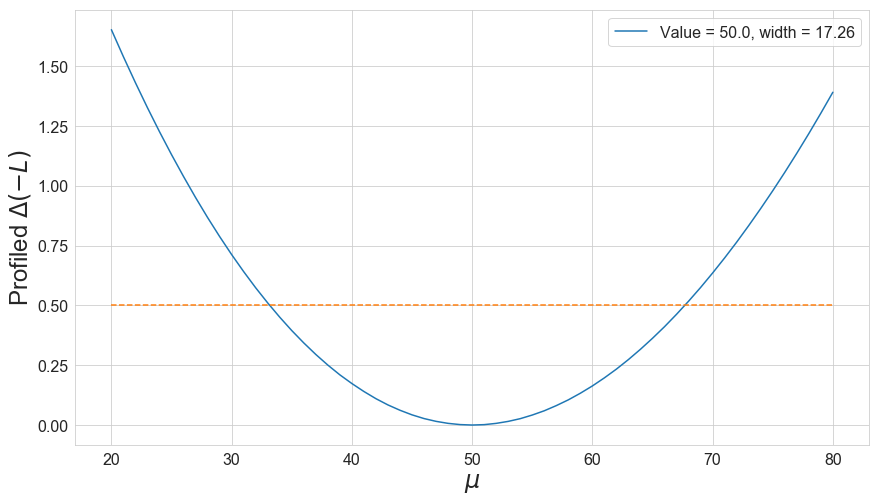

In [42]:
plot_likelihood(nll-nll.min())

## BM 3

In [43]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [44]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [45]:
nll = to_np(nll)

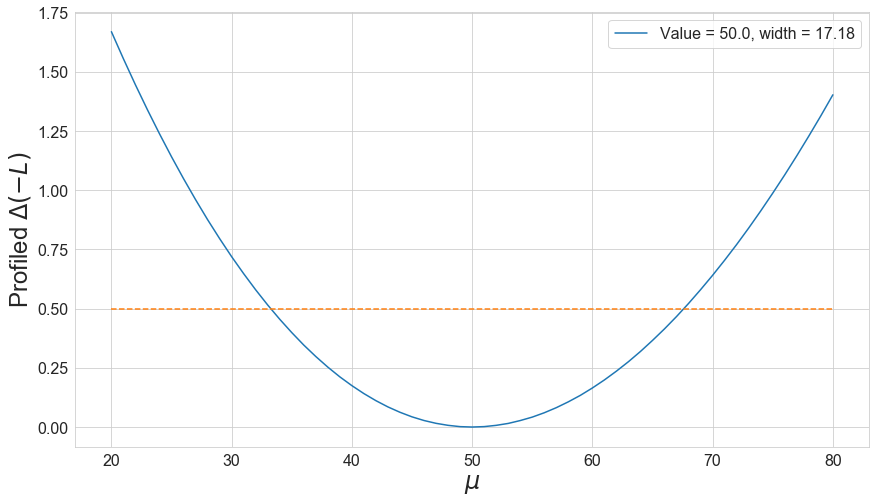

In [46]:
plot_likelihood(nll-nll.min())

## BM 4

In [47]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [48]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3119,  0.2065, 25.5618])
Linear regime: Mu 21.0, alpha tensor([-0.3014,  0.1972, 24.6376])
Linear regime: Mu 22.0, alpha tensor([-0.2909,  0.1881, 23.7188])
Linear regime: Mu 23.0, alpha tensor([-0.2804,  0.1791, 22.8055])
Linear regime: Mu 24.0, alpha tensor([-0.2700,  0.1703, 21.8974])
Linear regime: Mu 25.0, alpha tensor([-0.2595,  0.1617, 20.9947])
Linear regime: Mu 26.0, alpha tensor([-0.2491,  0.1532, 20.0973])
Linear regime: Mu 27.0, alpha tensor([-0.2387,  0.1449, 19.2050])
Linear regime: Mu 28.0, alpha tensor([-0.2282,  0.1368, 18.3178])
Linear regime: Mu 29.0, alpha tensor([-0.2178,  0.1289, 17.4358])
Linear regime: Mu 30.0, alpha tensor([-0.2074,  0.1211, 16.5588])
Linear regime: Mu 31.0, alpha tensor([-0.1970,  0.1135, 15.6868])
Linear regime: Mu 32.0, alpha tensor([-0.1866,  0.1061, 14.8197])
Linear regime: Mu 33.0, alpha tensor([-0.1762,  0.0988, 13.9576])
Linear regime: Mu 34.0, alpha tensor([-0.1658,  0.0917, 13.1002])
Linear reg

In [49]:
nll = to_np(nll)

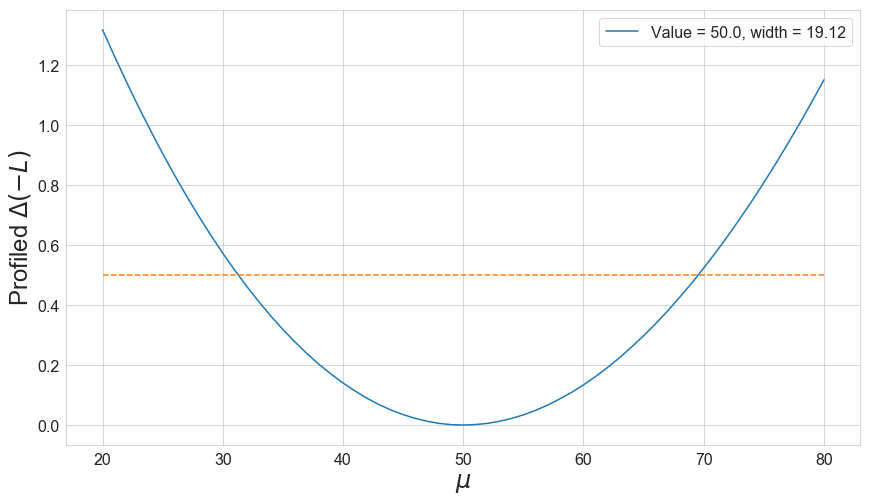

In [50]:
plot_likelihood(nll-nll.min())